# Week 1 Lab: next generation sequencing and mutation hunting

## Exercises (10 pts total)

**Due: Sunday 4/11/21 11:59pm**

Today's exercises will focus on understanding **sequencing coverage** and how to model coverage in the presence of **genetic variants** from the reference genome. We'll also get some practice with Python functions and plotting.

## 1. Exploring sequencing coverage

In next generation sequencing (NGS), coverage refers to the number of reads *covering* a particular base pair (bp) in the reference genome.

Recall from lecture that we sequence a genome in many little chunks, called *reads*. In a typical NGS experiment, reads are around 100bp each. We can assume that the start position of each read is chosen randomly from the genome (although that's not always an assumption that holds. sequencing coverage can be biased by many factors, such as GC content). We usually produce enough sequencing data such that we cover each base in the genome many times. This allows us to more accurately correct for errors and to detect **variants** from the reference genome.

As a toy example, consider the following reference genome and read alignment:

```
Ref:    AACTACGTACGTACGATCAGACTG
Read 1:      CGTACG
Read 2:          CGTACG
Read 3:                  CAGACT
```

The 11th position (G in the reference) is covered 2 times (often denoted as 2x). The first position (A in the reference) is covered 0 times. 

**Question 1 (2 pts):** How many times is the 13th base covered (it is an "A" in the reference)? Set the variable `cov` below to the correct answer.

In [1]:
cov = 1 # Set cov to the correct answer to Question 1

# YOUR CODE HERE
#raise NotImplementedError()

In [2]:
# Test that the answer for coverage is reasonable. Hidden tests check the actual value.
assert(cov in range(0, 4))


We can easily compute the *average coverage*, or mean number of times each base is covered, given the read length ($l$), genome size ($G$), and number of reads ($N$) by dividing the number of total sequenced bases ($l*N$) by the total genome size ($G$): 

$$\texttt{Mean Coverage} = \frac{lN}{G}$$

**Question 2 (2 pts):** For a genome of total length 2000bp, you sequenced 100,000 reads with length 36. What is the mean coverage? Set the variable `meancov` below to the correct answer.

In [3]:
meancov = -1 # Set meancov to the correct answer to Question 2

# YOUR CODE HERE
l = 36
n = 100000
G = 2000
meancov = l*n/G
#raise NotImplementedError()

In [4]:
# Test that the answer for mean coverage is reasonable. Hidden tests check the actual value
assert(meancov > 0 and meancov < 3000) # answer should be in this range
assert(int(meancov)==meancov) # should be a nice round number


**Question 3 (2 pts):** You would like to sequence a human genome (3 billion bp) to mean coverage 50x. Approximately how many 100bp reads should you generate? Set the variable `numreads` below to the correct answer.

In [5]:
numreads = 0 # Set numreads to the correct answer to Question 3

# YOUR CODE HERE
G = 3000000000
m = 50
l = 100
n = m*G/l
numreads = n
#raise NotImplementedError()

In [6]:
# Test that the answer for number of reads is reasonable. Hidden tests check the actual value
assert(numreads > 0 and numreads < 5000000000) # answer should be in this range
assert(int(numreads)==numreads) # should be a nice round number


## 2. Reviewing the binomial distribution

Now we will explore what our sequencing data will look like in the presence of variants from the reference genome. We'll also learn some terminology for how we talk about genetic variation. For simplicity, we will only consider simple base pair substitutions. Insertions, deletions, or structural variants will be discussed in later weeks.

Humans are *diploid*, meaning we have two copies of each chromosome (except X and Y). Positions in the genome that have common variants in the population are referred to as "single nucleotide polymorphisms", or SNPs. Nearly all SNPs are *bi-allelic*, meaning the position on any given copy of the chromosome in the population is either one of two possible base pairs (e.g. A or C). Each of these possible base pairs is called an *allele*.

For example, consider a SNP with two alleles, "C" or "T". Since we are diploid, the *genotype* of a person consists of the two alleles they have on either copy. So a person's *genotype* at this SNP could be either CC, CT, or TT. We refer to genotypes where both alleles are the same (e.g. CC or TT) as *homozygous* and to genotypes with two different alleles (e.g. CT) as *heterozygous*. Since one of these is usually the allele in the reference genome (*reference allele*), we can refer to SNP genotypes as *homozygous reference*, *heterozygous*, or *homozygous non-reference*.

Now let's think about what next-generation sequencing data will look like at different types of genotypes. Consider a position in the genome *covered* by $C$ reads. Each of those reads has a 50/50 chance of coming from either chromosome of an individual. For a homozygous position (e.g. genotype TT), we'd expect all of the reads covering that position to show the same base pair (T). On the other hand, for a heterozygous position (e.g. genotype CT), we'd expect about half of them to show one base pair (C) and half the other (T). (Of course when there are sequencing errors, this will change.)

The *binomial distribution* is a great way to model the number of reads with each allele at a heterozygous position. Head over to wikipedia to refresh your memory on this distribution: https://en.wikipedia.org/wiki/Binomial_distribution.

In a binomial distribution, we have $N$ total "trials", each with probability $p$ of "success". Then the probability of observing $k$ "successes" is:

$$ P(k) = {n \choose k} p^k(1-p)^{n-k}$$

Now let's adapt this to SNP calling. 

Let $N$ (number of trials) be the total number of reads covering a position and a "success" mean observing a non-reference allele. Since we observe each allele (reference vs. non-reference) with 50/50 chance, $p=0.5$. Then for a heterozygous position:

$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{het}) = {n \choose k} 0.5^k(1-0.5)^{n-k}$$
Simplifying:
$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{ het}) = {n \choose k} 0.5^n$$

And for the homozygous cases we just have:
$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{ hom. ref}) = \begin{array}{c c} 1 & k=0 \\ 0 & k>0\end{array}$$
$$ P(\texttt{observe }k\texttt{ non-reference reads} | \texttt{ hom. nonref}) = \begin{array}{c c} 1 & k=N \\ 0 & k<N \end{array}$$

This of course gets more complicated when you consider sequencing errors. That is, even if a position is homozygous for the reference allele, you may occasionally see evidence for a different base due to an error. But let's ignore that for now.

The functions below will plot the distribution of the number of reads matching the alternate allele for a SNP that is homozygous reference, heterozygous, or homozygous non-reference, for a given coverage N. Look through these functions and try to see how they implement the probability distributions above. If you are new to Python, you might check out [this page introducing Python functions](http://introtopython.org/introducing_functions.html). 

At the end of this code block, we plot the distributions of the number of reads matching the alternate allele for a SNP with C as the reference allele and T as the non-reference allele that we covered N=10 times:

Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


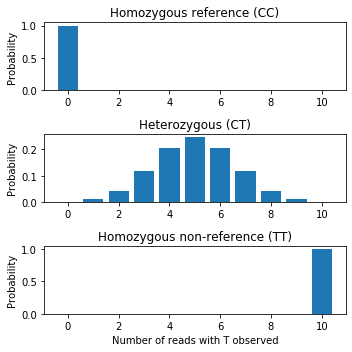

In [7]:
%pylab inline

import numpy as np
import scipy.special

def GetHomRefProb(N, k):
    """Probability to see k non-ref reads at a homozygous ref site with N total reads
    
    Parameters
    ----------
    N : int
       The total number of reads covering the position
    k : int
       The total number of reads matching the alternate allele
       
    Returns
    -------
    prob : float
       The probability of returning k reads matching the alt allele given
       N total sequencing reads at a genotype that is homozygous reference.
       
    Examples
    --------
    >>> GetHomRefProb(10, 0)
    1.0
    """
    if k == 0: return 1.0
    else: return 0.0
    
def GetHetProb(N, k):
    """Probability to see k non-ref reads at a heterozygous site with N total reads
    
    Parameters
    ----------
    N : int
       The total number of reads covering the position
    k : int
       The total number of reads matching the alternate allele
       
    Returns
    -------
    prob : float
       The probability of returning k reads matching the alt allele given
       N total sequencing reads at a genotype that is heterozygous.
       
    Examples
    --------
    >>> GetHetProb(10, 2)
    0.0439453125
    """
    return scipy.special.comb(N, k)*0.5**N

def GetHomNonRefProb(N, k):
    """Probability to see k non-ref reads at a homozygous non-ref site with N total reads
    
    Parameters
    ----------
    N : int
       The total number of reads covering the position
    k : int
       The total number of reads matching the alternate allele
       
    Returns
    -------
    prob : float
       The probability of returning k reads matching the alt allele given
       N total sequencing reads at a genotype that is homozygous non-reference.
       
    Examples
    --------
    >>> GetHomNonRefProb(10, 2)
    0.0
    """
    if k == N: return 1.0
    else: return 0.0

def PlotBinomSNP(N):
    """ Plot binomial probabilities for percent of nref reads given N total reads

    Parameters
    ----------
    N : int
       The total number of reads covering the position
    """
    kvals = range(0, N+1)

    fig = plt.figure()
    fig.set_size_inches((5, 5))

    ax = fig.add_subplot(311)
    hom_ref = [GetHomRefProb(N, k) for k in kvals]
    ax.bar(kvals, hom_ref)
    ax.set_title("Homozygous reference (CC)")
    ax.set_ylabel("Probability")

    ax = fig.add_subplot(312)
    het = [GetHetProb(N, k) for k in kvals]
    ax.bar(kvals, het)
    ax.set_title("Heterozygous (CT)")
    ax.set_ylabel("Probability")

    ax = fig.add_subplot(313)
    hom_nonref = [GetHomNonRefProb(N, k) for k in kvals]
    ax.bar(kvals, hom_nonref)
    ax.set_title("Homozygous non-reference (TT)")
    ax.set_xlabel("Number of reads with T observed")
    ax.set_ylabel("Probability")

    fig.tight_layout()
    
N = 10 # Number of reads at a position
PlotBinomSNP(N)

Take a look at these distributions and note:
* For homozygous reference genotypes ("CC"), we will only see reads that have "C". So the probablity that we see k=0 reads with a "T" is 1. The probability is 0 for all other values of k.
* For homozygous-nonreference genotypes ("TT"), we will see only reads that have a "T". So simiarly, the probablity that we see all 10 reads with a "T" is 1.
* For heterozygous genotypes (CT), about half the reads will be "C" and half will be "T". Since we're sampling from the individual's genotype with each read, we sometimes won't get exactly 50/50 (k=5 reads with "T"), but we'll get a distribution centered on that.

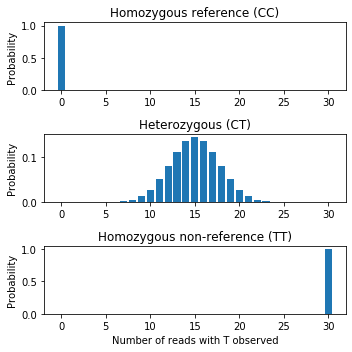

In [9]:
# You can edit N below to see how this looks for different values of coverage
N = 30 # Number of reads at a position
PlotBinomSNP(N)

**Question 4 (2 pts):** If the position is heterozygous for the reference allele (C) and another allele (T) and there are 10 reads covering it, what is the probability to see only 1 non-reference (T) read? Set the variable `prob` to your answer below. 

In [16]:
# Set the value of prob to the probability to see only 1 non-reference (T) read
# Hint: use a function defined above to make sure you get the right answer
prob = 0 
# YOUR CODE HERE
prob = GetHetProb(10, 1)
#raise NotImplementedError()

In [17]:
# Check prob was computed correctly.
# Note, hidden tests test the actual answer
assert(prob>=0 and prob <=1)

**Question 5 (2 pts):** Generate plots similar to above except with N=50 reads (you can do this in the cell above that contains the comment "You can edit N below..."). Try again with only N=3 reads. Try some more values for N.

At which coverage (N) will it be easiest to distinguish heterozygous vs. homozygous SNPs? 
A. 50
B. 3
C. 100

Set the variable `bestcov_answer` below to your answer.

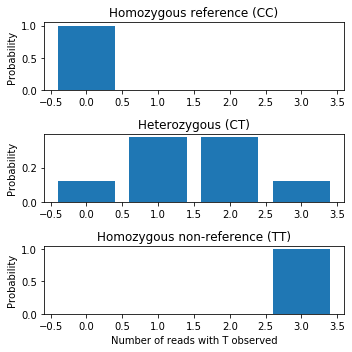

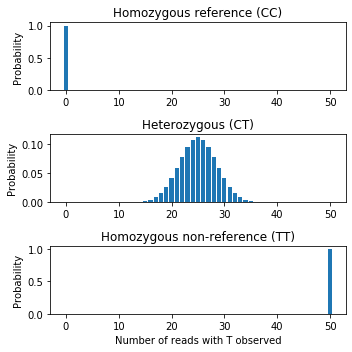

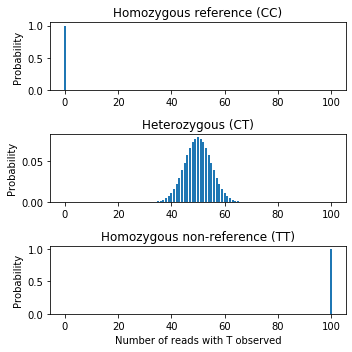

In [24]:
bestcov_answer = 'C' # set to either 'A', 'B', or 'C'

# YOUR CODE HERE
PlotBinomSNP(3)
PlotBinomSNP(50)
PlotBinomSNP(100)
#raise NotImplementedError()

In [25]:
# Test the value of bestcov_answer. Hidden tests check the actual value
assert(bestcov_answer in ['A','B','C','D'])
